In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from tqdm import tqdm

In [19]:
# ----- Constants -----
# Num of samples0
NUM_SAMPLES = 1000

# Kinetic parameters
MU_MAX = 0.810623399       # 1/h
K_S    = 0.000103       # g/l
Y_XS   = 0.419041856       # g/g
Y_PX   = 0.2              # g/g
S_F    = 1.43 * 200       # g/l

# Initial conditions
X_0 = 5.00
S_0 = 0.01
V_0 = 1.65

# Time parameters
T_START = 0
T_END = 40
TIME_RANGE = int(T_END - T_START)               # Absolute time 
TIME = np.linspace(T_START, T_END, NUM_SAMPLES) # Time vector

# MPC parameters
dt = TIME[1] - TIME[0]                         # Time step
L = int(TIME_RANGE / dt)                       # Simulation steps
N_p = 25                                       # Prediction horizon
Q = 10                                         # Weight for tracking
Q_term = 0.0                                   # Weight for terminal state
R = 0.1                                        # Weight for control effort
OPTIMIZATION_METHOD = 'SLSQP'                  # Optimization method. Other options: 'SLSQP, 'L-BFGS-B', 'trust-constr', 'COBYLA', 'Powell', 'Nelder-Mead'

# Bounds for feeding rate
F_MIN = 0.0                  # l/h
F_MAX = 0.1                  # l/h
DELTA_F_MAX = 0.05           # Maximum change in feed rate
F_0 = (F_MAX - F_MIN) / 2    # Initial feed rate
BOUNDS = [(F_MIN, F_MAX) for _ in range(N_p)] 

# Constraints for volume and substrate concentration
V_MAX = 2.0  # Maximum volume
S_MAX = 2 # Maximum substrate concentration
w_S = 0.0    # Weight for substrate constraint
w_V = 0.0    # Weight for volume constraint

# Initial conditions
X = np.zeros_like(TIME)
S = np.zeros_like(TIME)
V = np.zeros_like(TIME)
F = np.zeros_like(TIME)
X[0], S[0], V[0] = X_0, S_0, V_0

# Setpoint
X_SP = 25

In [22]:
def plant_model(t, y, F):
    X, S, V = y
    S = max(S, 0)
    dX_dt = (MU_MAX * S / (K_S + S)) * X - (F / V) * X
    dS_dt = -(1 / Y_XS) * (MU_MAX * S / (K_S + S)) * X + (F / V) * (S_F - S)
    dV_dt = F
    return np.array([dX_dt, dS_dt, dV_dt])

def discrete_model(X, S, V, F, h=0.1):
    k1 = plant_model(0, [X, S, V], F)
    k2 = plant_model(0 + h / 2, [X + k1[0] * h / 2, S + k1[1] * h / 2, V + k1[2] * h / 2], F)
    k3 = plant_model(0 + h / 2, [X + k2[0] * h / 2, S + k2[1] * h / 2, V + k2[2] * h / 2], F)
    k4 = plant_model(0 + h, [X + k3[0] * h, S + k3[1] * h, V + k3[2] * h], F)

    X_next = X + (h / 6) * (k1[0] + 2 * k2[0] + 2 * k3[0] + k4[0])
    S_next = S + (h / 6) * (k1[1] + 2 * k2[1] + 2 * k3[1] + k4[1])
    V_next = V + (h / 6) * (k1[2] + 2 * k2[2] + 2 * k3[2] + k4[2])
    return X_next, S_next, V_next

def cost_function(F_opt, X, S, V, t):
    J = 0
    X_curr, S_curr, V_curr = X, S, V
    for k in range(N_p):
        X_next, S_next, V_next = discrete_model(X_curr, S_curr, V_curr, F_opt[k])
        J += Q * (X_SP - X_next) ** 2  # Tracking error
        if k > 0:
            J += R * (F_opt[k] - F_opt[k - 1]) ** 2  # Penalization of fast input changes
        X_curr, S_curr, V_curr = X_next, S_next, V_next
    return J

X = np.zeros(L + 1)
S = np.zeros(L + 1)
V = np.zeros(L + 1)
F = np.zeros(L)
X[0], S[0], V[0] = X_0, S_0, V_0

for step in tqdm(range(L)):
    t = step * dt    
    res = minimize(cost_function, np.ones(N_p) * F_0, args=(X[step], S[step], V[step], t), bounds=BOUNDS, method=OPTIMIZATION_METHOD)
    F_MPC = res.x[0]
    sol = solve_ivp(plant_model, t_span=[t, t + dt], y0=[X[step], S[step], V[step]], args=(F_MPC,), method='LSODA', t_eval=[t + dt])
    F[step] = F_MPC
    F[step] = np.clip(F[step] + np.clip(F_MPC - F[step], -DELTA_F_MAX, DELTA_F_MAX), F_MIN, F_MAX)  # Enforce Δp ≤ 20
    X[step+1], S[step+1], V[step+1] = sol.y[:, -1]

100%|██████████| 999/999 [00:32<00:00, 30.42it/s]


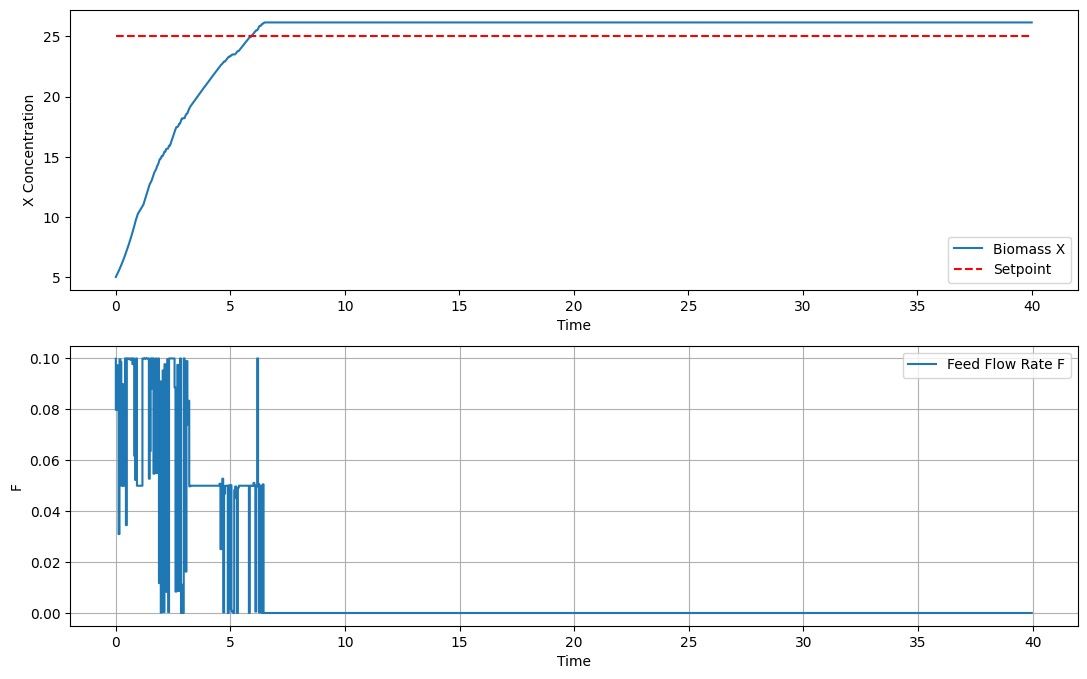

In [23]:
# Σχεδίαση Αποτελεσμάτων
plt.figure(figsize=(13, 8))
plt.subplot(2, 1, 1)
plt.plot(np.arange(0,TIME_RANGE+dt,dt), X, label="Biomass X")
plt.plot(np.arange(0,TIME_RANGE+dt,dt), [X_SP for t in np.arange(0,TIME_RANGE+dt,dt)], "r--", label="Setpoint")
plt.xlabel("Time")
plt.ylabel("X Concentration")
plt.legend()

plt.subplot(2, 1, 2)
plt.step(np.arange(0,TIME_RANGE,dt), F, label="Feed Flow Rate F")
plt.xlabel("Time")
plt.ylabel("F")
plt.legend()

plt.grid()
plt.show()